# **Llamadeus: A small music model**

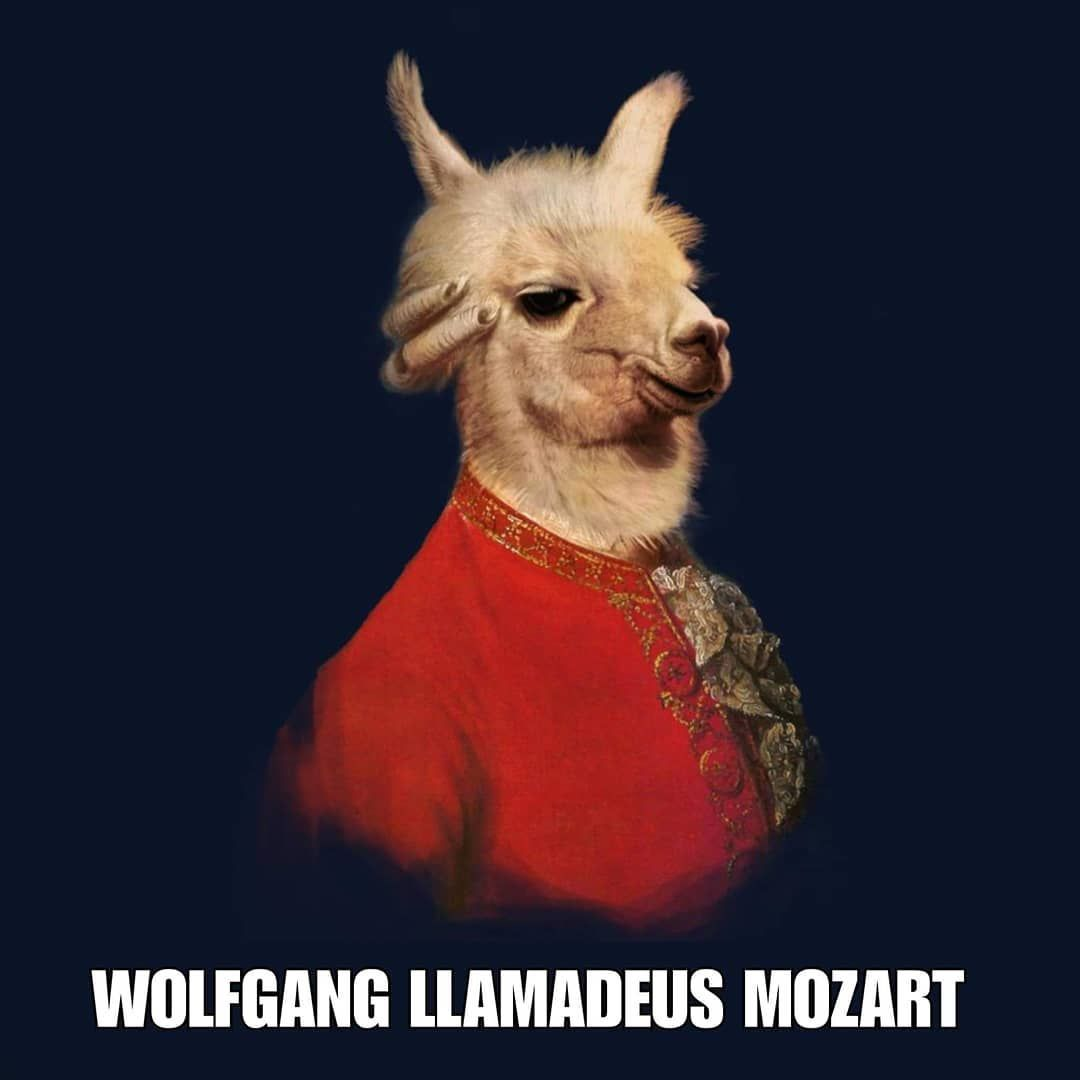

This notebook contains all the code necessary to generate original music.  It offers three prompts: an empty prompt that lets the model decide, a prompt from the model's training data, and a prompt that the model has not trained on.  It is also possible to adjust the sequence length, temperature, and whether or not the output should be entirely deterministic.

The cells for controlling these aspects of music generation can be found under the headings "Choose a prompt" and "Enter parameters for generating music"



### Nota bene: This notebook requires T4 (or better) to run in Google Colab


In [1]:
!pip install midi-player
!pip install mido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import math

# for parsing and playing MIDI files
import mido


# for importing the model weights
import requests
from google.colab import drive
import gdown

from datetime import datetime

### Event Tokenizer code

In [3]:
import mido
import numpy as np


class EventTokenizer:
    """Encodes MIDI files to event-based representation.
    Decodes event vectors back to MIDI (with default tempo and time-signature)"""


    nb_waits = 2000

    #data augmentation parameters
    nb_transpose_above = 12
    nb_transpose_below = 12

    #for writing MIDI only
    velocity = 127
    write_tempo = 800000

    def __init__(self, max_nb_voices) -> None:
        self.nb_voices = max_nb_voices
        self.vocab_size = 0

        self.events = (
            ['start', 'end'] +
            ['wait_'+str(i) for i in range(EventTokenizer.nb_waits)] +
            ['note_on_'+str(i) for i in range(21, 109)] + #21-108 midi pitches for entire keyboard
            ['note_off_'+str(i) for i in range(21, 109)] +
            ['switch_to_voice_'+str(i) for i in range(max_nb_voices)]  #first track of metadata doesn't count
        )
        self.vocab_size = len(self.events)

        self.event_map = {event:idx for idx,event in enumerate(self.events)}
        #self.event_map['end'] = EventTokenizer.end_token #might not be a good idea

        self.inv_event_map = None #lazy instanciation


    def file_to_vector(self, filepath: str, augment=False, return_mask=False) -> np.ndarray:
        return self.midi_to_vector(mido.MidiFile(filepath), augment=augment, return_mask=return_mask)


    def _encode(self, messages: mido.midifiles.tracks.MidiTrack, return_mask: bool = False) -> np.ndarray:
        #clocks = 0
        current_channel = 0
        current_note = [None for _ in range(self.nb_voices)]
        vector = [self.event_map['start']]
        for i,message in enumerate(messages):
            if isinstance(message, mido.MetaMessage):
                if message.type == 'end_of_track':
                    vector.append(self.event_map['end'])
                    break
                continue
            if message.channel != current_channel:
                vector.append(self.event_map['switch_to_voice_'+str(message.channel)])
                current_channel = message.channel
            if message.time > 0:
                vector.append(self.event_map['wait_'+str(message.time)])
                #clock += message.time
            if message.type == 'note_on':
                vector.append(self.event_map['note_on_'+str(message.note)])
                current_note[current_channel - 1] = message.note
            elif message.type == 'note_off':
                vector.append(self.event_map['note_off_'+str(message.note)])
                if message.note != current_note[current_channel - 1]:
                    print(f"wrong note...iteration {i}")
                current_note[current_channel - 1] = None
            else:
                print(f"Unknown message type: {message.type}")
        if vector[-1] != self.event_map['end']:
            print("It never ended...")
            vector.append(self.event_map['end'])
        print(f"Final iteration {i}")
        if return_mask:
            return vector, [1 for _ in range(len(vector))]
        return vector


    def _encode_and_augment(self, messages: mido.midifiles.tracks.MidiTrack, return_mask=False) -> np.ndarray:
        #clocks = [0 for _ in range(self.nb_voices)]
        current_channel = 0
        vector = [[self.event_map['start']] for _ in range(12)]

        started = False

        for message in messages:
            if isinstance(message, mido.MetaMessage):
                if message.type == 'end_of_track':
                    for row in vector:
                        row.append(self.event_map['end'])
                    break
                continue

            if message.channel != current_channel or not started:
                for row in vector:
                    row.append(self.event_map['switch_to_voice_'+str(message.channel)])
                current_channel = message.channel
                started = True
            if message.time > 0:
                for row in vector:
                    row.append(self.event_map['wait_'+str(message.time)])
            if message.type == 'note_on':
                for augmentation_offset, row in zip(range(-EventTokenizer.nb_transpose_below, EventTokenizer.nb_transpose_above + 1), vector):
                    row.append(self.event_map['note_on_'+str(message.note + augmentation_offset)])
            elif message.type == 'note_off':
                for augmentation_offset, row in zip(range(-EventTokenizer.nb_transpose_below, EventTokenizer.nb_transpose_above + 1), vector):
                    row.append(self.event_map['note_off_'+str(message.note + augmentation_offset)])
                # if message.note != current_note[current_channel - 1]:
                #     print("wrong note...")
                # current_note[current_channel - 1] = None
            else:
                print(f"Unknown message type: {message.type}")
        if vector[1][-1] != self.event_map['end']:
            print("It never ended...")
            vector.append(self.event_map['end'])
        if return_mask:
            return vector, [1 for _ in range(len(vector))]
        return vector


    def midi_to_vector(self, mid: mido.midifiles.midifiles.MidiFile, augment: bool = False, return_mask: bool = False) -> np.ndarray:
        if len(mid.tracks) - 1 > self.nb_voices:
            raise Exception(f"Insufficient number of voices: tokenizer has {self.nb_voices}, MIDI has {len(mid.tracks) - 1}")
        #print(mid.__dict__.keys())
        #print(mid.__dir__())
        #merged = mid.merge_tracks(mid.tracks, skip_checks=True)
        if augment:
            return self._encode_and_augment(mid.merged_track, return_mask=return_mask)
        else:
            return self._encode(mid.merged_track, return_mask=return_mask)


    def vector_to_midi(self, vector: np.ndarray, output_filepath: str = None) -> mido.midifiles.midifiles.MidiFile:
        if self.inv_event_map is None:
            self.inv_event_map = {v:k for k,v in self.event_map.items()}
        mid = mido.MidiFile()

        #just to put something down for metadata
        metatrack = mido.MidiTrack([
            mido.MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
            mido.MetaMessage('set_tempo', tempo=EventTokenizer.write_tempo, time=0),
            mido.MetaMessage('end_of_track', time=0)
        ])
        mid.tracks.append(metatrack)
        tracks = [mido.MidiTrack() for _ in range(self.nb_voices)]
        for i, track in enumerate(tracks):
            track.append(mido.MetaMessage('text', 'voice_'+str(i), time=0))
            mid.tracks.append(track)

        current_channel = 0
        clocks = [0 for _ in range(self.nb_voices)]
        #started = [False for _ in range(self.nb_voices)]
        global_clock = 0
        if isinstance(vector, list):
            events = vector
        elif isinstance(vector, np.ndarray):
            events = vector.flatten()
        else:
            raise Exception(f"Unsupported vector type: {type(vector)}")

        for event_code in events:
            event = self.inv_event_map[event_code]
            if event.startswith("e"):
                for track in tracks:
                    track.append(mido.MetaMessage('end_of_track', time=0))
            elif event.startswith("start"):
                continue
            elif event.startswith("s"):
                current_channel = int(event.split("_")[-1])
            elif event.startswith("w"):
                wait_time =  int(event.split("_")[-1])
                global_clock += wait_time
            elif event.startswith("note_on"):
                current_note = int(event.split("_")[-1])
                tracks[current_channel].append(
                    mido.Message('note_on',
                                 channel=current_channel,
                                 note=current_note,
                                 velocity=EventTokenizer.velocity,
                                 time=global_clock - clocks[current_channel])
                )
                clocks[current_channel] = global_clock
            elif event.startswith("note_off"):
                current_note = int(event.split("_")[-1])
                tracks[current_channel].append(
                    mido.Message('note_off',
                                 channel=current_channel,
                                 note=current_note,
                                 velocity=EventTokenizer.velocity,
                                 time=global_clock - clocks[current_channel])
                )
                clocks[current_channel] = global_clock
            else:
                print("unknown event...")
        if output_filepath is not None:
            mid.save(filename=output_filepath)
        return mid

### Transformer code


In [4]:
class MultiHeadAttention(nn.Module):
    """This is the heart of a Transformer"""
    def __init__(self, d_k, d_v, d_model, nb_heads):
        super().__init__()

        self.nb_heads = nb_heads
        self.d_k = d_k
        self.d_v = d_v

        #all heads together for efficiency
        self.query = nn.Linear(d_model, d_k * nb_heads)
        self.key = nn.Linear(d_model, d_k * nb_heads)
        self.value = nn.Linear(d_model, d_v * nb_heads)

        self.fc = nn.Linear(d_v * nb_heads, d_model)


    def forward(self, q, k, v, mask=None):
        q = self.query(q)   # batch_size x seq_length x (d_k * nb_heads)
        k = self.key(k)     # batch_size x seq_length x (d_k * nb_heads)
        v = self.value(v)   # batch_size x seq_length x (d_v * nb_heads)

        batch_size = q.shape[0]
        seq_length = q.shape[1]

        #separate the heads and reorder
        # batch_size x seq_length x nb_heads x d -> batch_size x nb_heads x seq_length x d
        q = q.view(batch_size, seq_length, self.nb_heads, self.d_k).transpose(1,2)
        k = k.view(batch_size, seq_length, self.nb_heads, self.d_k).transpose(1,2)
        v = v.view(batch_size, seq_length, self.nb_heads, self.d_v).transpose(1,2)

        # now I understand how tensor multiplication works :))) The last two dimensions are subjected to normal matmul
        # (batch_size x nb_heads x seq_length x d_k)(batch_size x nb_heads x d_k x seq_length) -> (batch_size x nb_heads x seq_length x seq_length)
        attention = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)

        if mask is not None:
            attention = attention.masked_fill(mask[:, None, None, :] == 0, float('-inf')) #None fills in the gaps in the shape with ones.

        # apply softmax along the last dimension
        attention = F.softmax(attention, dim = -1)

        # apply attention to the values
        # (batch_size x nb_heads x seq_length x seq_length)(batch_size x nb_heads x seq_length x d_v) -> (batch_size x nb_heads x seq_length x d_v)
        attention = attention @ v

        # need (batch_size x seq_length x (nb_heads * d_v))
        attention = attention.transpose(1,2).contiguous().view(batch_size, seq_length, self.nb_heads * self.d_v)

        return self.fc(attention)



#use the MultiHeadAttention to implement a Transformer block
class TransformerBlock(nn.Module):
    """max_len=None => encoder model"""
    def __init__(self, d_k, d_v, d_model, nb_heads, max_len=None, d_ff=None, dropout_proba=0.1):
        super().__init__()
        if max_len is not None:
            self.mha = CausalSelfAttention(d_k, d_v, d_model, nb_heads, max_len)
        else:
            self.mha = MultiHeadAttention(d_k, d_v, d_model, nb_heads)
        self.dropout1 = nn.Dropout(dropout_proba)
        if d_ff is None:
            d_ff = d_model * 4 #default...seems like this is a popular choice?
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),  #or ReLU or...?
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout_proba),
        )
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        attention_out = self.mha(x, x, x, mask)
        #dropout option
        drop1 = self.dropout1(attention_out)
        add_norm1 = self.layer_norm1(x + drop1)
        ff_out = self.ff(add_norm1)
        add_norm2 = self.layer_norm2(add_norm1 + ff_out)
        #option to dropout here too
        return add_norm2



class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout_proba=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_proba)
        position = torch.arange(max_len).unsqueeze(1)
        # equivalent to 10000 ^ (-2*i/d_model), which will be like dividing by 10000 ^ (2*i/d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.) / d_model)) #someone at pytorch thinks this exp and -log business is safer!
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # batch_size x seq_length x embedding_dim
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class CausalSelfAttention(MultiHeadAttention):
    """Also known as 'Masked Self Attention,' this is multihead attention which uses a mask to force the model to make predictions using only preceding tokens."""
    def __init__(self, d_k, d_v, d_model, nb_heads, max_len):
        super().__init__(d_k, d_v, d_model, nb_heads)
        #lower triangular of ones
        causal_mask = torch.tril(torch.ones(max_len, max_len))
        self.register_buffer('causal_mask', causal_mask.view(1, 1, max_len, max_len))

    def forward(self, q, k, v, pad_mask=None):
        q = self.query(q)   # batch_size x seq_length x (d_k * nb_heads)
        k = self.key(k)     # batch_size x seq_length x (d_k * nb_heads)
        v = self.value(v)   # batch_size x seq_length x (d_v * nb_heads)

        batch_size = q.shape[0]
        seq_length = q.shape[1]

        #separate the heads and reorder
        # batch_size x seq_length x nb_heads x d -> batch_size x nb_heads x seq_length x d
        q = q.view(batch_size, seq_length, self.nb_heads, self.d_k).transpose(1,2)
        k = k.view(batch_size, seq_length, self.nb_heads, self.d_k).transpose(1,2)
        v = v.view(batch_size, seq_length, self.nb_heads, self.d_v).transpose(1,2)

        # (batch_size x nb_heads x seq_length x d_k)(batch_size x nb_heads x d_k x seq_length) -> (batch_size x nb_heads x seq_length x seq_length)
        attention = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)

        if pad_mask is not None:
            attention = attention.masked_fill(
                pad_mask[:, None, None, :] == 0, float('-inf')
            )
        attention = attention.masked_fill(
            self.causal_mask[:, :, :seq_length, :seq_length] == 0, float('-inf')
        )
        attention = F.softmax(attention, dim = -1)

        # apply attention to the values
        # (batch_size x nb_heads x seq_length x seq_length)(batch_size x nb_heads x seq_length x d_v) -> (batch_size x nb_heads x seq_length x d_v)
        attention = attention @ v

        # need (batch_size x seq_length x (nb_heads * d_v))
        attention = attention.transpose(1,2).contiguous().view(batch_size, seq_length, self.nb_heads * self.d_v)

        return self.fc(attention)


class Decoder(nn.Module):
    """This is the model class for the transformer"""
    def __init__(self,
                    d_k,
                    d_v,
                    d_model,
                    nb_heads,
                    nb_layers,
                    dropout_proba,
                    max_len,
                    vocab_size,
                    d_ff=None):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoding(d_model, dropout_proba, max_len)
        blocks = [
            TransformerBlock(d_k, d_v, d_model, nb_heads, max_len, d_ff=d_ff, dropout_proba=dropout_proba)
            for _ in range(nb_layers)
        ]
        self.transformer_blocks = nn.Sequential(*blocks)
        self.layer_norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x, pad_mask=None):
        x = self.embedding(x)
        x = self.pe(x)
        if pad_mask is not None:
            for block in self.transformer_blocks:
                x = block(x, pad_mask)
        else:
            x = self.transformer_blocks(x)
        x = self.layer_norm(x)
        x = self.fc(x)
        return x


## Download model weights

In [5]:
shared_link = 'https://drive.google.com/file/d/1XNk7IkBX7wIYhQGnMHjYB8RNkpkAkTdT/view?usp=drive_link'

# Convert the shared link to a format that allows downloading the file
# Example link: https://drive.google.com/file/d/FILE_ID/view?usp=sharing
# Change it to: https://drive.google.com/uc?id=FILE_ID
file_id = shared_link.split('/d/')[1].split('/view')[0]
download_link = f"https://drive.google.com/uc?id={file_id}"


model_path = '/content/music_transformer.pth'

# Download the model file
gdown.download(download_link, model_path, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1XNk7IkBX7wIYhQGnMHjYB8RNkpkAkTdT
From (redirected): https://drive.google.com/uc?id=1XNk7IkBX7wIYhQGnMHjYB8RNkpkAkTdT&confirm=t&uuid=d0b31ff2-2b88-49c6-8977-bd7aa4712952
To: /content/music_transformer.pth
100%|██████████| 126M/126M [00:00<00:00, 225MB/s]


'/content/music_transformer.pth'

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


#old model trained on 2-3 part inventions
load_path=model_path

Device: cuda:0


In [7]:
# load and prepare the model
checkpoint = torch.load(model_path)
model_state_dict = checkpoint['model_state_dict']
init_args = checkpoint['init_args']
model = Decoder(**init_args)
model.load_state_dict(model_state_dict)
model.to(device)
model.eval()

Decoder(
  (embedding): Embedding(2181, 128)
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (mha): CausalSelfAttention(
        (query): Linear(in_features=128, out_features=64, bias=True)
        (key): Linear(in_features=128, out_features=64, bias=True)
        (value): Linear(in_features=128, out_features=64, bias=True)
        (fc): Linear(in_features=64, out_features=128, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=128, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerBlock(
      (mha): CausalSelfAtt

## Choose a prompt

The model can take a fragment of music as a prompt, or start from scratch.


Uncomment one of the blocks of code only.

In [8]:
# # This starts the model with a fragment of music it has NOT seen before
# prompt_list = [0, 2179, 122, 2049, 62, 2137, 2048, 62, 2136, 2049, 122, 2137, 2044, 122, 2132, 2045, 122, 2133, 2049, 62, 2048, 5, 2137, 59, 2136, 2049, 122, 2137, 2051, 122]
# prompt = torch.tensor([prompt_list])
# mask = torch.tensor([[1 for _ in range(30)]])



# # This starts the model with a fragment of music it HAS seen before
# prompt_list = [0,2178,2044,2032,122,2120,2036,122,2124,2034,52,2132,12,2044,62,2132,2043,2122,2032,62,2131,2041,62,2129,2039,2120,2031,122,2127,2041]
# prompt = torch.tensor([prompt_list]).to(device)
# mask = torch.tensor([[1 for _ in range(30)]]).to(device)



# Empty prompt and mask - start token only
prompt = torch.tensor([[0]]).to(device)
mask = torch.tensor([[1]]).to(device)


# Enter parameters for generating music



DETERMINISTIC : If False, the model will sample each token from a multinomial distribution generated from the model's output logits.  Otherwise, the token will be the argmax of the output logits, rendering the model entirely deterministic.

TEMPERATURE : Must be GREATER than 0.  A small value (like 0.1) approaches determinism, whereas a large value (1 or greater) is much more random and unpredictable.

MAX_NB_TOKENS : How long should the model generate before stopping

In [12]:
# Choose whether or not the model should generate deterministically
# Temperature should be greater than 0.  Close to 0 is nearly deterministic, greater than 1 is quite random
DETERMINISTIC = False
TEMPERATURE = 1.3
MAX_NB_TOKENS = 2000




################### No need to modify below this line ##########################
USE_SOFTMAX = not DETERMINISTIC
NB_VOICES = 3

# Generate music

In [13]:
prompt_gen = prompt.clone().to(device)
mask_gen = mask.clone().to(device)


for _ in range(MAX_NB_TOKENS):
    outputs = model(prompt_gen, mask_gen)

    if USE_SOFTMAX:
        probas = F.softmax(outputs[:,-1,:] / TEMPERATURE, dim=1)
        prediction = torch.multinomial(probas, num_samples=1).squeeze(-1)
    else:
        prediction = torch.argmax(outputs[:,-1,:], axis=-1) #last one = predicted next
    prompt_gen = torch.hstack((prompt_gen, prediction.view(1, 1))).to(device)
    mask_gen = torch.ones_like(prompt_gen).to(device)


# Convert to a list
prompt_gen = np.array(prompt_gen.cpu()).flatten()

final_version = []
for i in prompt_gen:
    final_version.append(i)


if final_version[-1] != 1:
  final_version.append(1)

now = datetime.now()
formatted_date = now.strftime("%Y-%m-%d_%H:%M:%S")


# Tokenize and write to MIDI file
tok = EventTokenizer(NB_VOICES)
midi_file_path = f"/content/song_{formatted_date}.mid"
tok.vector_to_midi(final_version, midi_file_path)


print(f"Here are the generated tokens:\n{final_version}")

print(f"\n\nAnd here are the generated events:")
for token in final_version:
  print(tok.inv_event_map[token])

Here are the generated tokens:
[0, 2178, 2033, 2040, 2121, 2035, 122, 2128, 2043, 2123, 2037, 122, 2125, 2038, 122, 2126, 2040, 122, 2128, 2038, 122, 2126, 2035, 122, 2123, 2043, 122, 2131, 2042, 122, 2043, 122, 2131, 2045, 2123, 2037, 122, 2133, 2047, 122, 2135, 2045, 2125, 2038, 122, 2133, 2047, 122, 2135, 2049, 122, 2137, 2045, 122, 2133, 2044, 2126, 2040, 122, 2132, 2045, 122, 2133, 2047, 112, 2135, 12, 2048, 2128, 2038, 122, 2136, 2050, 2126, 2033, 122, 2138, 12, 2045, 2121, 2031, 122, 2119, 2033, 122, 2121, 2035, 122, 2133, 2041, 2123, 2036, 122, 2124, 2038, 122, 2129, 2043, 122, 2131, 2042, 2126, 2040, 122, 2128, 2042, 122, 2130, 2043, 2126, 2035, 122, 2131, 2045, 2123, 2036, 122, 2124, 2038, 122, 2133, 2043, 2126, 2040, 122, 2131, 2045, 2128, 2042, 122, 2130, 2036, 62, 2124, 2035, 122, 2123, 2036, 32, 2124, 2038, 32, 2129, 2040, 2126, 2036, 122, 2124, 2035, 122, 2123, 2036, 122, 2131, 2042, 2124, 2035, 122, 2121, 2031, 122, 2126, 2043, 2123, 2033, 122, 2131, 2042, 2119, 2033, 1

# Play the generated music

A player should appear: click the play button and enjoy!

In [14]:
from midi_player import MIDIPlayer
from midi_player.stylers import basic, cifka_advanced


MIDIPlayer(midi_file_path, 160, styler=cifka_advanced, title='My Player')